# MARKETING EFFECTIVENESS - GRUPO 1

## Importación de las librerías

In [57]:
import pandas as pd
import numpy as np

from pandas import Series, DataFrame

# Training and test spliting
from sklearn.cross_validation import train_test_split
from sklearn import preprocessing

# Estimators
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression


# Evaluation
from sklearn import metrics
from sklearn.cross_validation import cross_val_score, KFold, StratifiedKFold
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

# Optimization
from sklearn.grid_search import GridSearchCV

# Visualisation
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(color_codes=True)

%matplotlib inline

## Carga de Datos

In [58]:
df_sample_submission=pd.read_csv('./sample_submission.csv')
df_test_novel=pd.read_csv('test_nolabel.csv')
df_train=pd.read_csv('train.csv')
df_train.head()

,id,age,job,marital,education,default,housing,loan,contact,month,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,44dc8df9,35,admin.,married,high.school,unknown,no,no,telephone,jul,...,1,999,0,nonexistent,1.4,93.918,-42.7,4.963,5228.1,0
1,3f62aa06,52,technician,married,basic.9y,no,no,no,telephone,jun,...,1,999,0,nonexistent,1.4,94.465,-41.8,4.967,5228.1,0
2,34bd6148,44,blue-collar,single,basic.9y,no,no,no,cellular,may,...,4,999,1,failure,-1.8,92.893,-46.2,1.244,5099.1,0
3,e1671cba,35,admin.,married,high.school,no,yes,yes,telephone,jun,...,9,999,0,nonexistent,1.4,94.465,-41.8,4.959,5228.1,0
4,c20477f0,33,technician,married,university.degree,no,yes,no,cellular,jul,...,7,999,0,nonexistent,1.4,93.918,-42.7,4.968,5228.1,0


## Preprocesado de datos

In [59]:
df_train.isnull().sum()

id                0
age               0
job               0
marital           0
education         0
default           0
housing           0
loan              0
contact           0
month             0
day_of_week       0
duration          0
campaign          0
pdays             0
previous          0
poutcome          0
emp.var.rate      0
cons.price.idx    0
cons.conf.idx     0
euribor3m         0
nr.employed       0
y                 0
dtype: int64

In [60]:
df_test_novel['job'] = pd.get_dummies(df_test_novel['job'])
df_train['job'] = pd.get_dummies(df_train['job'])

df_test_novel['marital'] = pd.get_dummies(df_test_novel['marital'])
df_train['marital'] = pd.get_dummies(df_train['marital'])

df_test_novel['education'] = pd.get_dummies(df_test_novel['education'])
df_train['education'] = pd.get_dummies(df_train['education'])

df_test_novel['default'] = pd.get_dummies(df_test_novel['default'])
df_train['default'] = pd.get_dummies(df_train['default'])

df_test_novel['housing'] = pd.get_dummies(df_test_novel['housing'])
df_train['housing'] = pd.get_dummies(df_train['housing'])

df_test_novel['loan'] = pd.get_dummies(df_test_novel['loan'])
df_train['loan'] = pd.get_dummies(df_train['loan'])

df_test_novel['contact'] = pd.get_dummies(df_test_novel['contact'])
df_train['contact'] = pd.get_dummies(df_train['contact'])

df_test_novel['month'] = pd.get_dummies(df_test_novel['month'])
df_train['month'] = pd.get_dummies(df_train['month'])

df_test_novel['day_of_week'] = pd.get_dummies(df_test_novel['day_of_week'])
df_train['day_of_week'] = pd.get_dummies(df_train['day_of_week'])

df_test_novel['poutcome'] = pd.get_dummies(df_test_novel['poutcome'])
df_train['poutcome'] = pd.get_dummies(df_train['poutcome'])

In [61]:
features=[#'id',
 'age',
 'job',
 'marital',
 'education',
 'default',
 'housing',
 'loan',
 'contact',
 'month',
 'day_of_week',
 'duration',
 'campaign',
 'pdays',
 'previous',
 'poutcome',
 'emp.var.rate',
 'cons.price.idx',
 'cons.conf.idx',
 'euribor3m',
 'nr.employed']

/Users/jgc/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in log10
  if __name__ == '__main__':


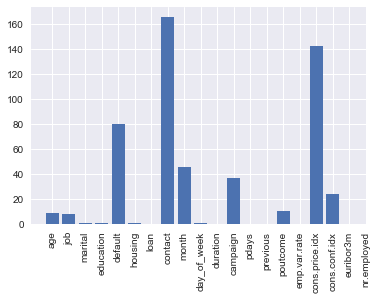

In [62]:
from sklearn.feature_selection import SelectKBest, f_classif

X = df_train[features].values
y = df_train['y'].values

kbest=SelectKBest(f_classif,k=6)
kbest.fit_transform(X, y)

scores = -np.log10(kbest.pvalues_)

plt.bar(range(len(features)), scores)
plt.xticks(range(len(features)), features, rotation='vertical')
plt.show()

X_kbest = kbest.transform(df_train[features].values)
#print("X original shape: "+str(df_train[features].values.shape))
#print("X kbest shape: "+str(X_kbest.shape))

df_test_novel_transformed = kbest.transform(df_test_novel[features].values)
X_train, X_test, y_train, y_test = train_test_split(X_kbest, y, test_size=0.25, random_state=33)


array([[ 1.8900e+02,  9.9900e+02,  0.0000e+00,  1.4000e+00,  4.9630e+00,
         5.2281e+03],
       [ 1.8800e+02,  9.9900e+02,  0.0000e+00,  1.4000e+00,  4.9670e+00,
         5.2281e+03],
       [ 2.6700e+02,  9.9900e+02,  1.0000e+00, -1.8000e+00,  1.2440e+00,
         5.0991e+03],
       ...,
       [ 1.3500e+02,  9.9900e+02,  1.0000e+00, -1.8000e+00,  1.4050e+00,
         5.0991e+03],
       [ 4.8000e+02,  6.0000e+00,  1.0000e+00, -1.7000e+00,  8.1000e-01,
         4.9916e+03],
       [ 2.7000e+01,  9.9900e+02,  0.0000e+00,  1.4000e+00,  4.9620e+00,
         5.2281e+03]])

## DecisionTreeClassifier

In [99]:
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
import numpy as np

param_grid = {
    'max_depth': np.arange(1, 10), 
    'max_leaf_nodes': np.arange(2, 30),
    'criterion': ["gini", "entropy"],
    'class_weight': ["balanced", None],
    'max_features': ["auto", "sqrt", "log2", None]
} 

gs = GridSearchCV(DecisionTreeClassifier(), param_grid)

gs.fit(X_train, y_train)

print("Best score: ", gs.best_score_)
print("Best params: ", gs.best_params_)

model = DecisionTreeClassifier(
    class_weight=gs.best_params_["class_weight"], 
    max_leaf_nodes=gs.best_params_["max_leaf_nodes"], 
    max_depth=gs.best_params_["max_depth"],
    criterion=gs.best_params_["criterion"],
    max_features=gs.best_params_["max_features"]
)
model.fit(X_train, y_train)
print()
print("Cross Val Score: "+str(cross_val_score(model, X_test, y_test)))
print("Model Score: "+str(model.score(X_test,y_test)))

Best score:  0.9144836225636491
Best params:  {'class_weight': None, 'criterion': 'entropy', 'max_depth': 6, 'max_features': None, 'max_leaf_nodes': 24}

Cross Val Score: [0.90683024 0.91511936 0.91144279]
Model Score: 0.9141151763015364


In [101]:
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
import numpy as np

# RESULT FROM GRID SEARCH:
# Best score:  0.9144836225636491
# Best params:  {'class_weight': None, 'criterion': 'entropy', 'max_depth': 6, 'max_features': None, 'max_leaf_nodes': 24}

model = DecisionTreeClassifier(
    class_weight=None, 
    max_leaf_nodes=24, 
    max_depth=6,
    criterion="entropy",
    max_features=None
)
model.fit(X_train, y_train)
print()
print("Cross Val Score: "+str(cross_val_score(model, X_test, y_test)))
print("Model Score: "+str(model.score(X_test,y_test)))


Cross Val Score: [0.90683024 0.91511936 0.91144279]
Model Score: 0.9141151763015364


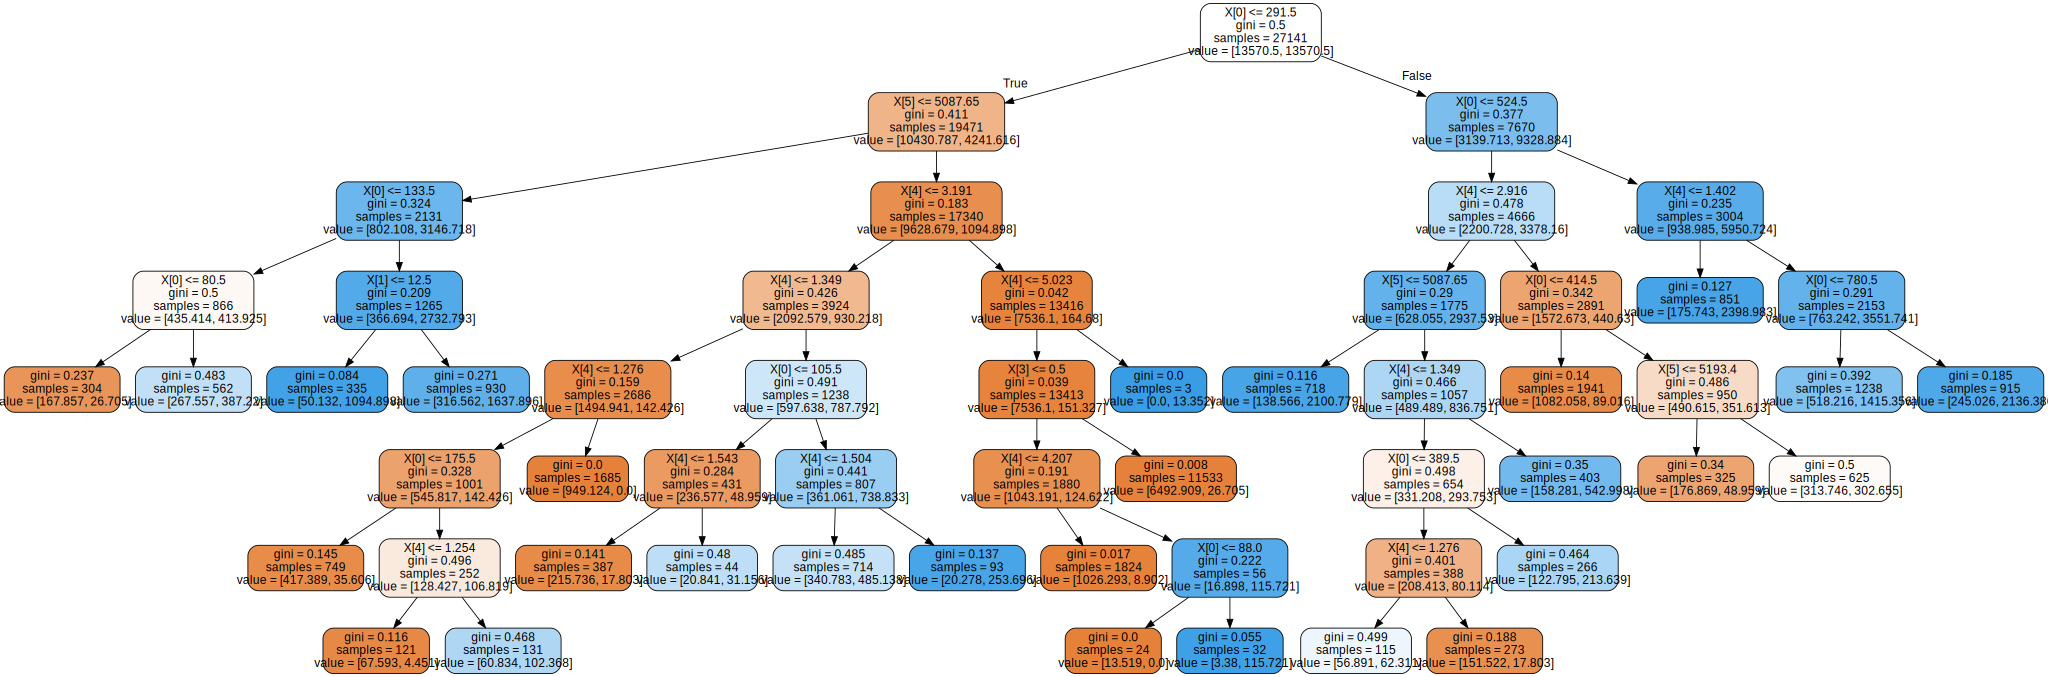

In [96]:
from sklearn.tree import export_graphviz
import graphviz 

dot_data = export_graphviz(model, 
                            out_file=None, 
                            filled=True, 
                            rounded=True)  
graph = graphviz.Source(dot_data)  
graph 

## DecisionTreeRegressor

In [70]:
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeRegressor
import numpy as np

param_grid = {'max_depth': np.arange(1, 30), 'max_leaf_nodes': np.arange(2, 30)} 

gs = GridSearchCV(DecisionTreeRegressor(), param_grid)

gs.fit(X_train, y_train)

# summarize the results of the grid search
print("Best score: ", gs.best_score_)
print("Best params: ", gs.best_params_)

Best score:  0.4060298149662342
Best params:  {'max_depth': 7, 'max_leaf_nodes': 26}


In [74]:
from sklearn.tree import DecisionTreeRegressor

model = DecisionTreeRegressor()
model.fit(X_train, y_train)
print("Cross Val Score: "+str(cross_val_score(model, X_test, y_test)))
print("Model Score: "+str(model.score(X_test,y_test)))

Cross Val Score: [-0.09772318 -0.12544461 -0.16257579]
Model Score: -0.11632527045771757


# Realizar predicción para Kaggle

In [102]:
#Realizar prediccion
#print("df_test_novel_transformed.shape: "+str(df_test_novel_transformed.shape))
#print("X_train.shape: "+str(X_train.shape))
#print("y_train.shape: "+str(y_train.shape))
#print("X_kbest.shape: "+str(X_kbest.shape))

predicted = model.predict(df_test_novel_transformed)
output = pd.DataFrame( data={"id":df_test_novel.id, "y":predicted} )
output_order = ['id','y']
output[output_order].to_csv('Labels.csv', index=False, quoting=3)
output.head()

,id,y
0,897212bf,0
1,2ad6d4ae,0
2,a193003e,0
3,3f639630,0
4,dfe76b9d,0
